<a href="https://colab.research.google.com/github/YuzhouLin/current_proj/blob/feature-20210203-devtest/plot_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn import metrics

In [8]:
tmp_R = pd.read_csv(os.getcwd()+f"/results/etcn0/sb1d1_t1_T1.csv")

In [24]:
a = {'vac': 1, 'diss':2}
print('vac' in a.keys())

True


In [3]:
def cal_minAP(n_pos, n_neg):
    # theoretical minimum average precision
    AP_min = 0.0
    for i in range(1, n_pos + 1):
        AP_min += i / (i + n_neg)
    AP_min = AP_min / n_pos
    return AP_min

def cal_mis_pm(labels, scores):
    #  calculate the misclassification performance measures
    #  include AUROC, AP, nAP
    #  labels: labels for postive or not
    #  scores: quantified uncertainty; dict
    n_sample = len(labels)  # the total number of predictions
    n_pos = np.sum(labels)  # the total number of positives
    n_neg = n_sample - n_pos  # the total number of negatives
    skew = n_pos / n_sample
    #AUROC = {key: [] for key in scores}
    AP = {key: [] for key in scores}
    nAP = {key: [] for key in scores}

    if skew == 0:  # No postive samples found
        #  PR curve makes no sense, record it but dont use it
        for un_type, un_score in scores.items():
            AP[un_type] = float("nan")  # AP
            nAP[un_type] = float("nan")  # normalised AP
    else:
        minAP = cal_minAP(n_pos, n_neg)
        for un_type, un_score in scores.items():
            #AUROC[un_type] = metrics.roc_auc_score(labels, un_score)
            AP[un_type] = metrics.average_precision_score(labels, un_score)
            #  normalised AP
            nAP[un_type] = (AP[un_type] - minAP) / (1 - minAP)
    return nAP

def get_R(model, sb):
    day_n_list = []
    time_n_list = []
    trial_n_list = []
    R_nEntropy_list = []
    R_nnmp_list = []
    R_vac_list = []
    R_diss_list = []
    R_overall_list = []
    for day_n in range(1,6):
        for t_n in range(1,3):
            for T_n in range(1,13):
                tmp_R = pd.read_csv(os.getcwd()+f"/results/{model}/sb{sb}d{day_n}_t{t_n}_T{T_n}.csv") # results
                # columns of tmp_R: window, actual, predict, entropy, un_prob, (vacuity,dissonance,) overall
                day_n_list.append(day_n)
                time_n_list.append('AM') if t_n == 1 else time_n_list.append('PM')
                #time_n_list.append(t_n)
                trial_n_list.append(T_n)
                misclassification_labels = np.logical_not(tmp_R['actual'] == tmp_R['predict'])
                un_labels = list(set(tmp_R.columns) - set(['window', 'actual','predict']))
                
                scores = {}
                for un_type in un_labels:
                    scores[un_type] = tmp_R[un_type] 
                nAPs = cal_mis_pm(misclassification_labels, scores)
                #print(nAPs)
                R_nEntropy_list.append(nAPs['entropy'])
                R_nnmp_list.append(nAPs['un_prob'])
                R_vac_list.append(nAPs['vacuity']) if 'vacuity' in nAPs.keys() else R_vac_list.append(pd.NA)
                R_diss_list.append(nAPs['dissonance']) if 'dissonance' in nAPs.keys() else R_diss_list.append(pd.NA) 
                R_overall_list.append(nAPs['overall'])
    
    n = len(R_nEntropy_list)
    R_dict={
            'model': [model]*n,
            'sb': [sb]*n,
            'day': day_n_list,
            'time': time_n_list,
            'trial': trial_n_list,
            'nEntropy': R_nEntropy_list,
            'nnmp': R_nnmp_list,
            'vacuity': R_vac_list,
            'dissonance': R_diss_list,
            'overall': R_overall_list
    }
    
    #df_new = pd.DataFrame(acc_dict, index=np.arange(0,n,1))
    df = pd.DataFrame(R_dict)
    return df



In [4]:
filename = './results/reliability_report.csv'
models = ['ecnn0', 'ecnn1', 'ecnn2', 'ecnn3', 'etcn0', 'etcn1', 'etcn2', 'etcn3']

for i in models:
    df_new = get_R(model=i, sb=1)
    if os.path.exists(filename):
        print('Update new')
        df = pd.read_csv(filename)
        df = df.append(df_new, ignore_index=True)
    else:
        print('Create new')
        df = df_new
    df.to_csv(filename, index=False)
    
df_R = pd.read_csv(filename)


Update new
Update new
Update new
Update new
Update new
Update new
Update new
Update new


In [5]:
df_R_summary = df_R.groupby(by=['day', 'time','model']).mean().unstack()


In [6]:
df_R_summary['overall']

model        ecnn0     ecnn1     ecnn2     ecnn3     etcn0     etcn1  \
day time                                                               
1   AM    0.259652  0.454202  0.594147  0.479981  0.448975  0.508601   
    PM    0.345423  0.411932  0.549940  0.444758  0.436444  0.500933   
2   AM    0.542159  0.505807  0.570063  0.553253  0.582662  0.535548   
    PM    0.543104  0.508743  0.592324  0.525013  0.568801  0.533373   
3   AM    0.511300  0.462316  0.569632  0.519965  0.525891  0.490298   
    PM    0.561166  0.577555  0.605887  0.557914  0.546171  0.546543   
4   AM    0.547471  0.501945  0.614113  0.550798  0.565060  0.525155   
    PM    0.514236  0.476997  0.596473  0.532294  0.524806  0.489025   
5   AM    0.522481  0.503196  0.528081  0.539592  0.581540  0.541495   
    PM    0.566130  0.557851  0.554289  0.574025  0.591142  0.558197   

model        etcn2     etcn3  
day time                      
1   AM    0.639076  0.605511  
    PM    0.614971  0.567685  
2   AM    0.605806  0.585628  
    PM    0.587427  0.586497  
3   AM    0.552966  0.556547  
    PM    0.581583  0.558483  
4   AM    0.564121  0.581574  
    PM    0.550270  0.545237  
5   AM    0.534295  0.569840  
    PM    0.604686  0.600975

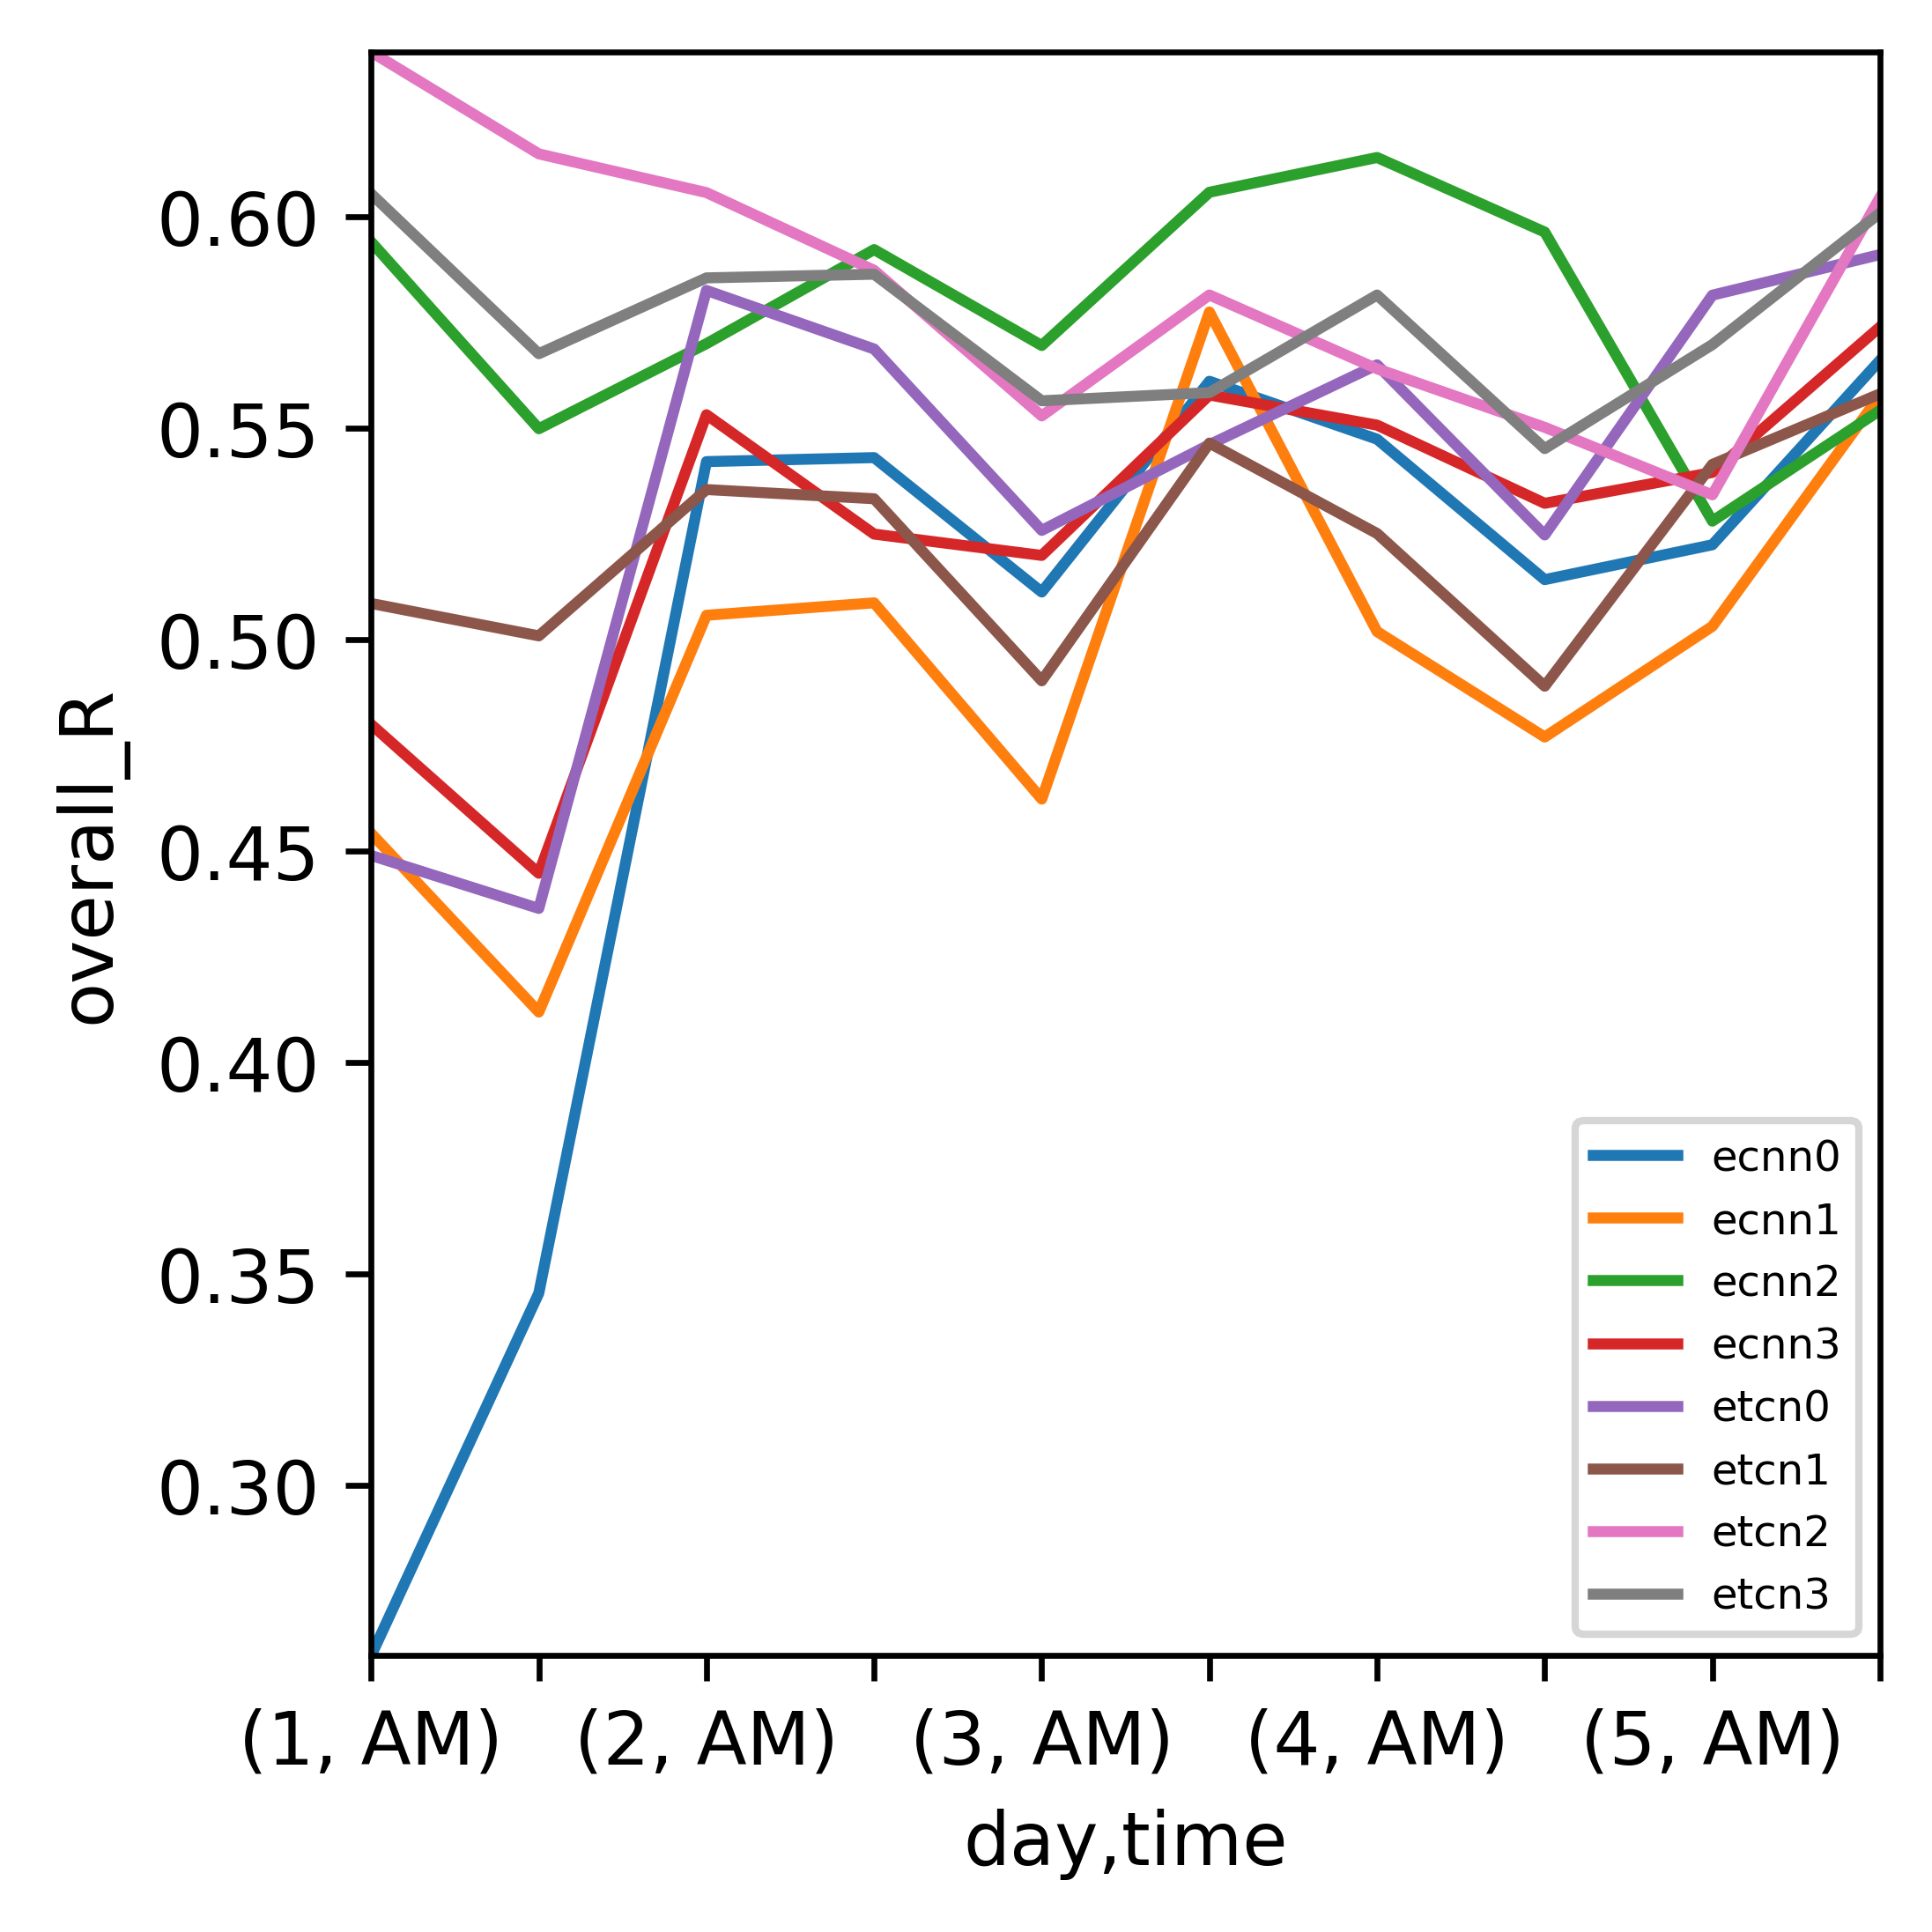

In [7]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1,1, figsize = (7.08/2, 7.08/2), constrained_layout=True,dpi=600)
df_R_summary['overall'].plot(kind='line', ylabel='overall_R', ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(10))
ax.autoscale(tight=True)
#ax.xaxis.set_ticks([(1,2,3,4,5), ('AM','PM')])  
ax.legend(loc='best', fontsize='xx-small')
plt.savefig("./analysis/line-reliability.png", format='png', bbox_inches='tight', dpi=600, pad_inches=0.0)

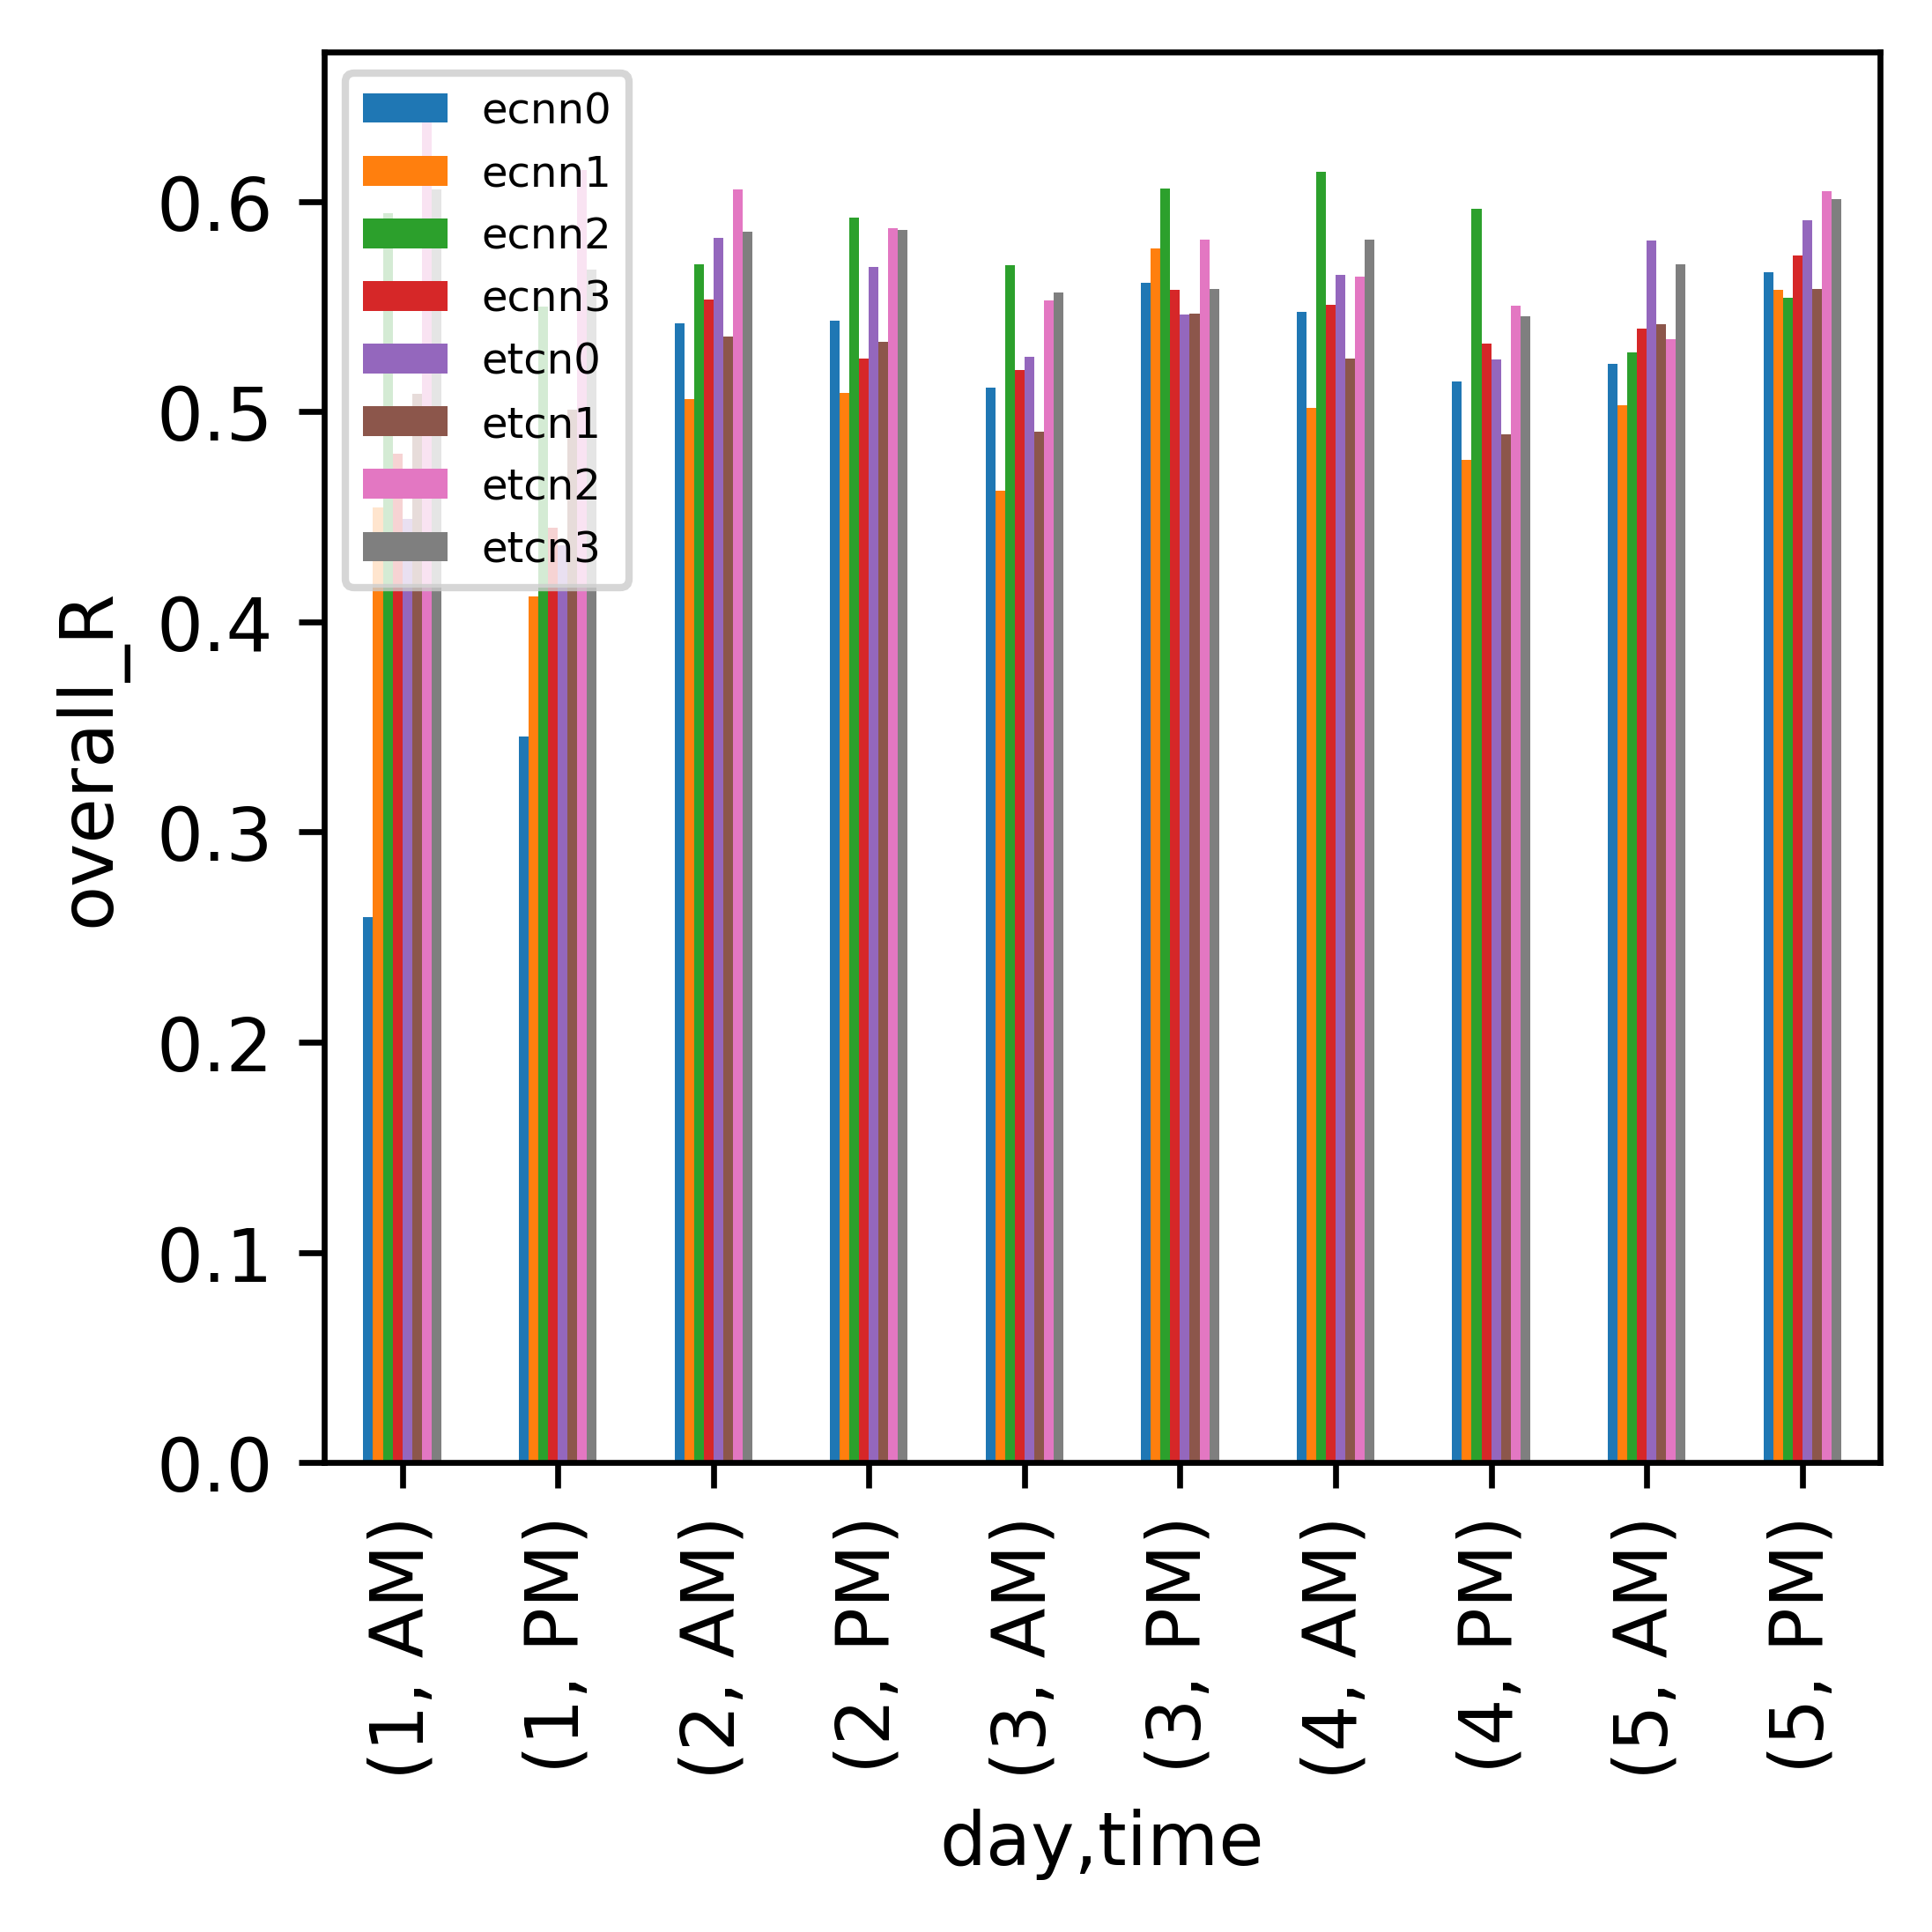

In [8]:
fig, ax = plt.subplots(1,1, figsize = (7.08/2, 7.08/2), constrained_layout=True,dpi=600)
df_R_summary['overall'].plot(kind='bar', ax=ax, ylabel='overall_R')
ax.legend(loc='best', fontsize='xx-small')
#plt.savefig("./results/bar-acc.png", format='png', bbox_inches='tight', dpi=600, pad_inches=0.0)
plt.savefig("./analysis/bar-reliability.png", format='png', bbox_inches='tight', dpi=600)

In [9]:
def get_acc(model, sb):
    
    day_n_list = []
    time_n_list = []
    trial_n_list = []
    acc_list = []
    
    for day_n in range(1,6):
        for t_n in range(1,3):
            for T_n in range(1,13):
                tmp_R = pd.read_csv(os.getcwd()+f"/results/{model}/sb{sb}d{day_n}_t{t_n}_T{T_n}.csv")
                day_n_list.append(day_n)
                time_n_list.append('AM') if t_n == 1 else time_n_list.append('PM')
                #time_n_list.append(t_n)
                trial_n_list.append(T_n)
                acc_list.append(np.sum(tmp_R['actual'] == tmp_R['predict'])/len(tmp_R['predict']))
    
    n = len(acc_list)
    acc_dict={
            'model': [model]*n,
            'sb': [sb]*n,
            'day': day_n_list,
            'time': time_n_list,
            'trial': trial_n_list,
            'acc': acc_list
    }
    
    #df_new = pd.DataFrame(acc_dict, index=np.arange(0,n,1))
    df = pd.DataFrame(acc_dict)
    return df

filename = './analysis/acc_report.csv'
models = ['ecnn0', 'ecnn1', 'ecnn2', 'ecnn3', 'etcn0', 'etcn1', 'etcn2', 'etcn3']

for i in models:
    df_new = get_acc(model=i, sb=1)
    if os.path.exists(filename):
        print('Update new')
        df = pd.read_csv(filename)
        df = df.append(df_new, ignore_index=True)
    else:
        print('Create new')
        df = df_new
    df.to_csv(filename, index=False)
    
df_acc = pd.read_csv(filename)

Update new
Update new
Update new
Update new
Update new
Update new
Update new
Update new


In [10]:
df_acc_summary = df_acc.groupby(by=['day', 'time','model']).mean().unstack()





In [11]:
df_acc_summary['acc']

model        ecnn0     ecnn1     ecnn2     ecnn3     etcn0     etcn1  \
day time                                                               
1   AM    0.958443  0.890310  0.611510  0.908545  0.809039  0.784781   
    PM    0.948813  0.882244  0.619383  0.916399  0.821655  0.765676   
2   AM    0.706340  0.693928  0.507324  0.644245  0.649553  0.619530   
    PM    0.670938  0.638595  0.518479  0.653233  0.617134  0.586137   
3   AM    0.665959  0.665229  0.498456  0.627195  0.620636  0.594684   
    PM    0.508997  0.524779  0.403184  0.554999  0.397297  0.400597   
4   AM    0.685479  0.661194  0.543088  0.665216  0.652752  0.600564   
    PM    0.694072  0.701726  0.466969  0.639683  0.640601  0.604128   
5   AM    0.611144  0.602259  0.427507  0.567096  0.507352  0.518756   
    PM    0.647297  0.635560  0.465037  0.586276  0.573958  0.551252   

model        etcn2     etcn3  
day time                      
1   AM    0.554320  0.724304  
    PM    0.546104  0.726291  
2   AM    0.537018  0.600850  
    PM    0.515210  0.571228  
3   AM    0.523908  0.561243  
    PM    0.403647  0.386861  
4   AM    0.512827  0.575389  
    PM    0.542947  0.585926  
5   AM    0.479261  0.474948  
    PM    0.494033  0.527814

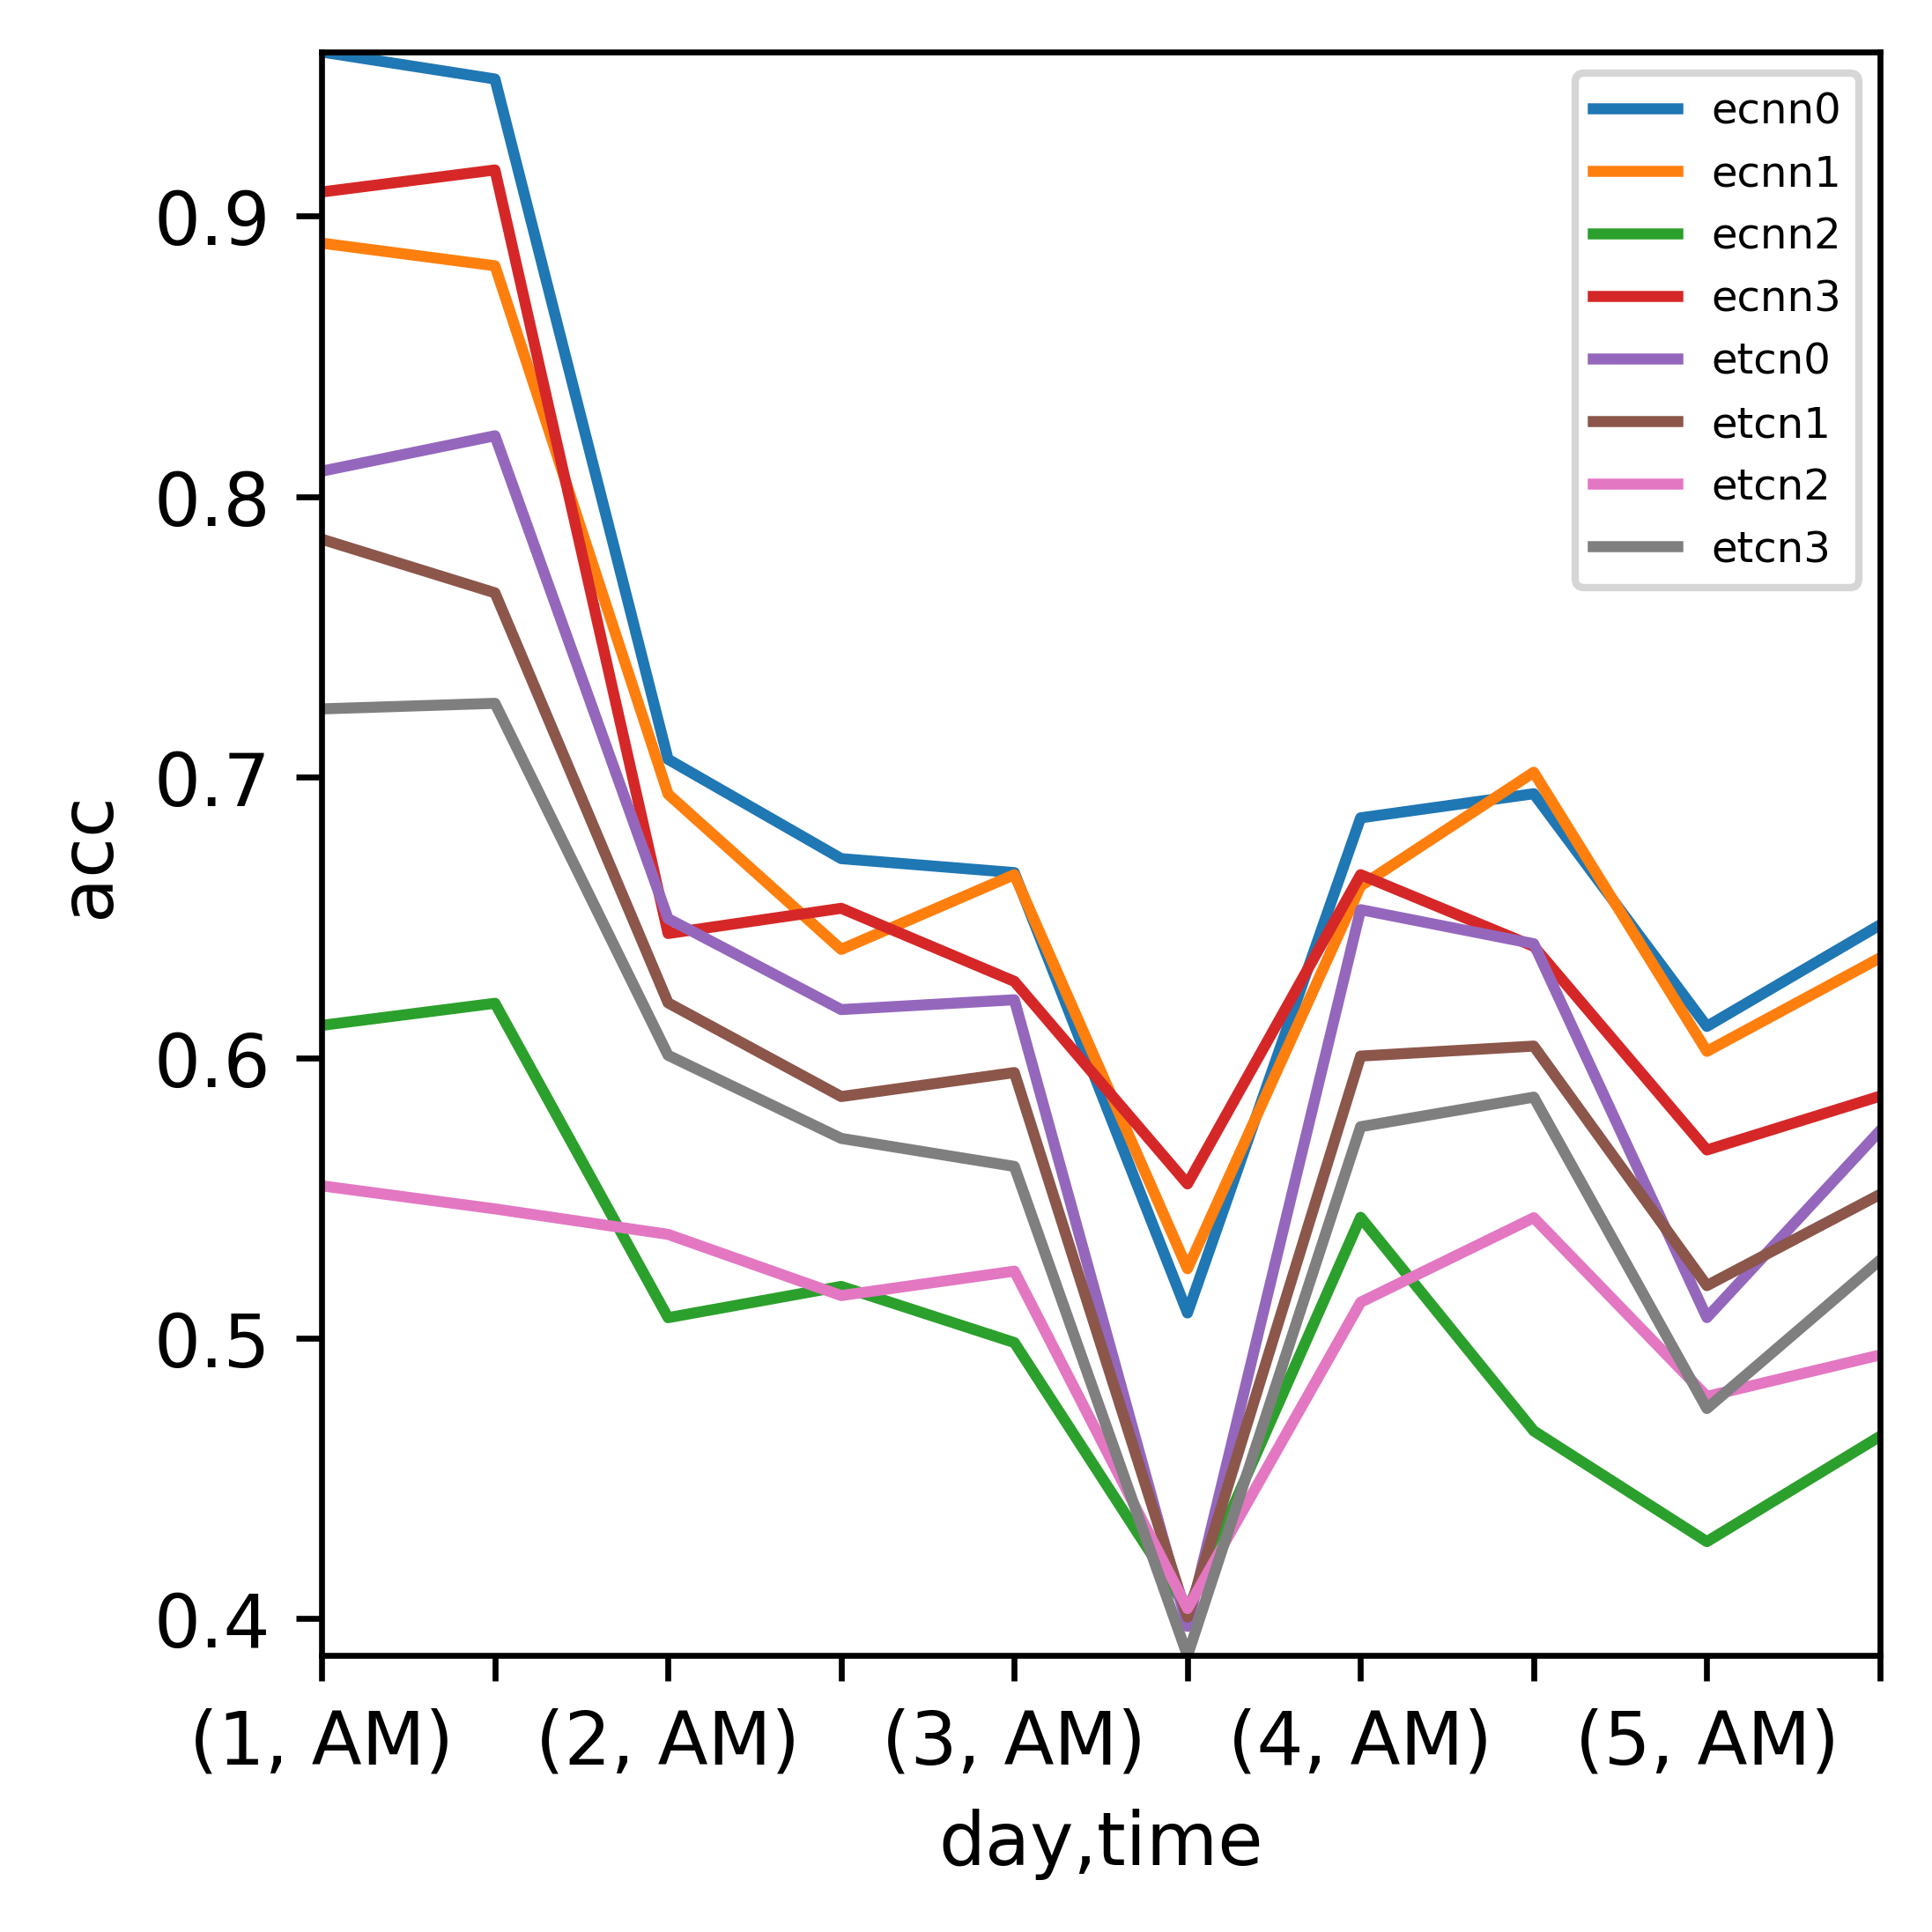

In [12]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1,1, figsize = (7.08/2, 7.08/2), constrained_layout=True,dpi=600)
#df_acc.groupby(['day','model']).mean().unstack().plot(kind='line', y='acc', ax=ax, rot=45, xticks=[1,2,3,4,5], ylabel='acc')
df_acc_summary['acc'].plot(kind='line', ylabel='acc', ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(10))
ax.autoscale(tight=True)
#ax.xaxis.set_ticks([(1,2,3,4,5), ('AM','PM')])  
ax.legend(loc='best', fontsize='xx-small')
plt.savefig("./analysis/line-acc.png", format='png', bbox_inches='tight', dpi=600, pad_inches=0.0)

'\ni=0\nfor ax in axes.ravel():\n    #sns.heatmap(CM[i], ax = ax, cmap=\'GnBu\')\n    sns.\n    colorbar = True if i==1 or i==3 else False\n    sns.heatmap(CM_model_ave[i], ax = ax, annot=True, cmap=\'Blues\', vmax=1, vmin=0, fmt=\'.2%\', annot_kws={\'size\': 4}, cbar=colorbar)\n    i+=1\n\n\nlabels = [\'CNN\',\'ECNN-A\',\'ECNN-B\',\'ECNN-C\']\nfor ax, label in zip(axes.ravel(), labels):\n    ax.set_title(label,loc=\'center\', fontdict={\'fontsize\': 8})\n    ax.set_xlabel(\'Predicted Finger Movement\', fontdict={\'fontsize\': 8})\n    ax.set_ylabel(\'Acutal Finger Movement\', fontdict={\'fontsize\': 8})\n\nplt.savefig("./results/confusion_matrix_macroave.eps", format=\'eps\', bbox_inches=\'tight\', dpi=600, pad_inches=0.0)\nplt.savefig("./results/confusion_matrix_macroave.png", format=\'png\', bbox_inches=\'tight\', dpi=600, pad_inches=0.0)\n'

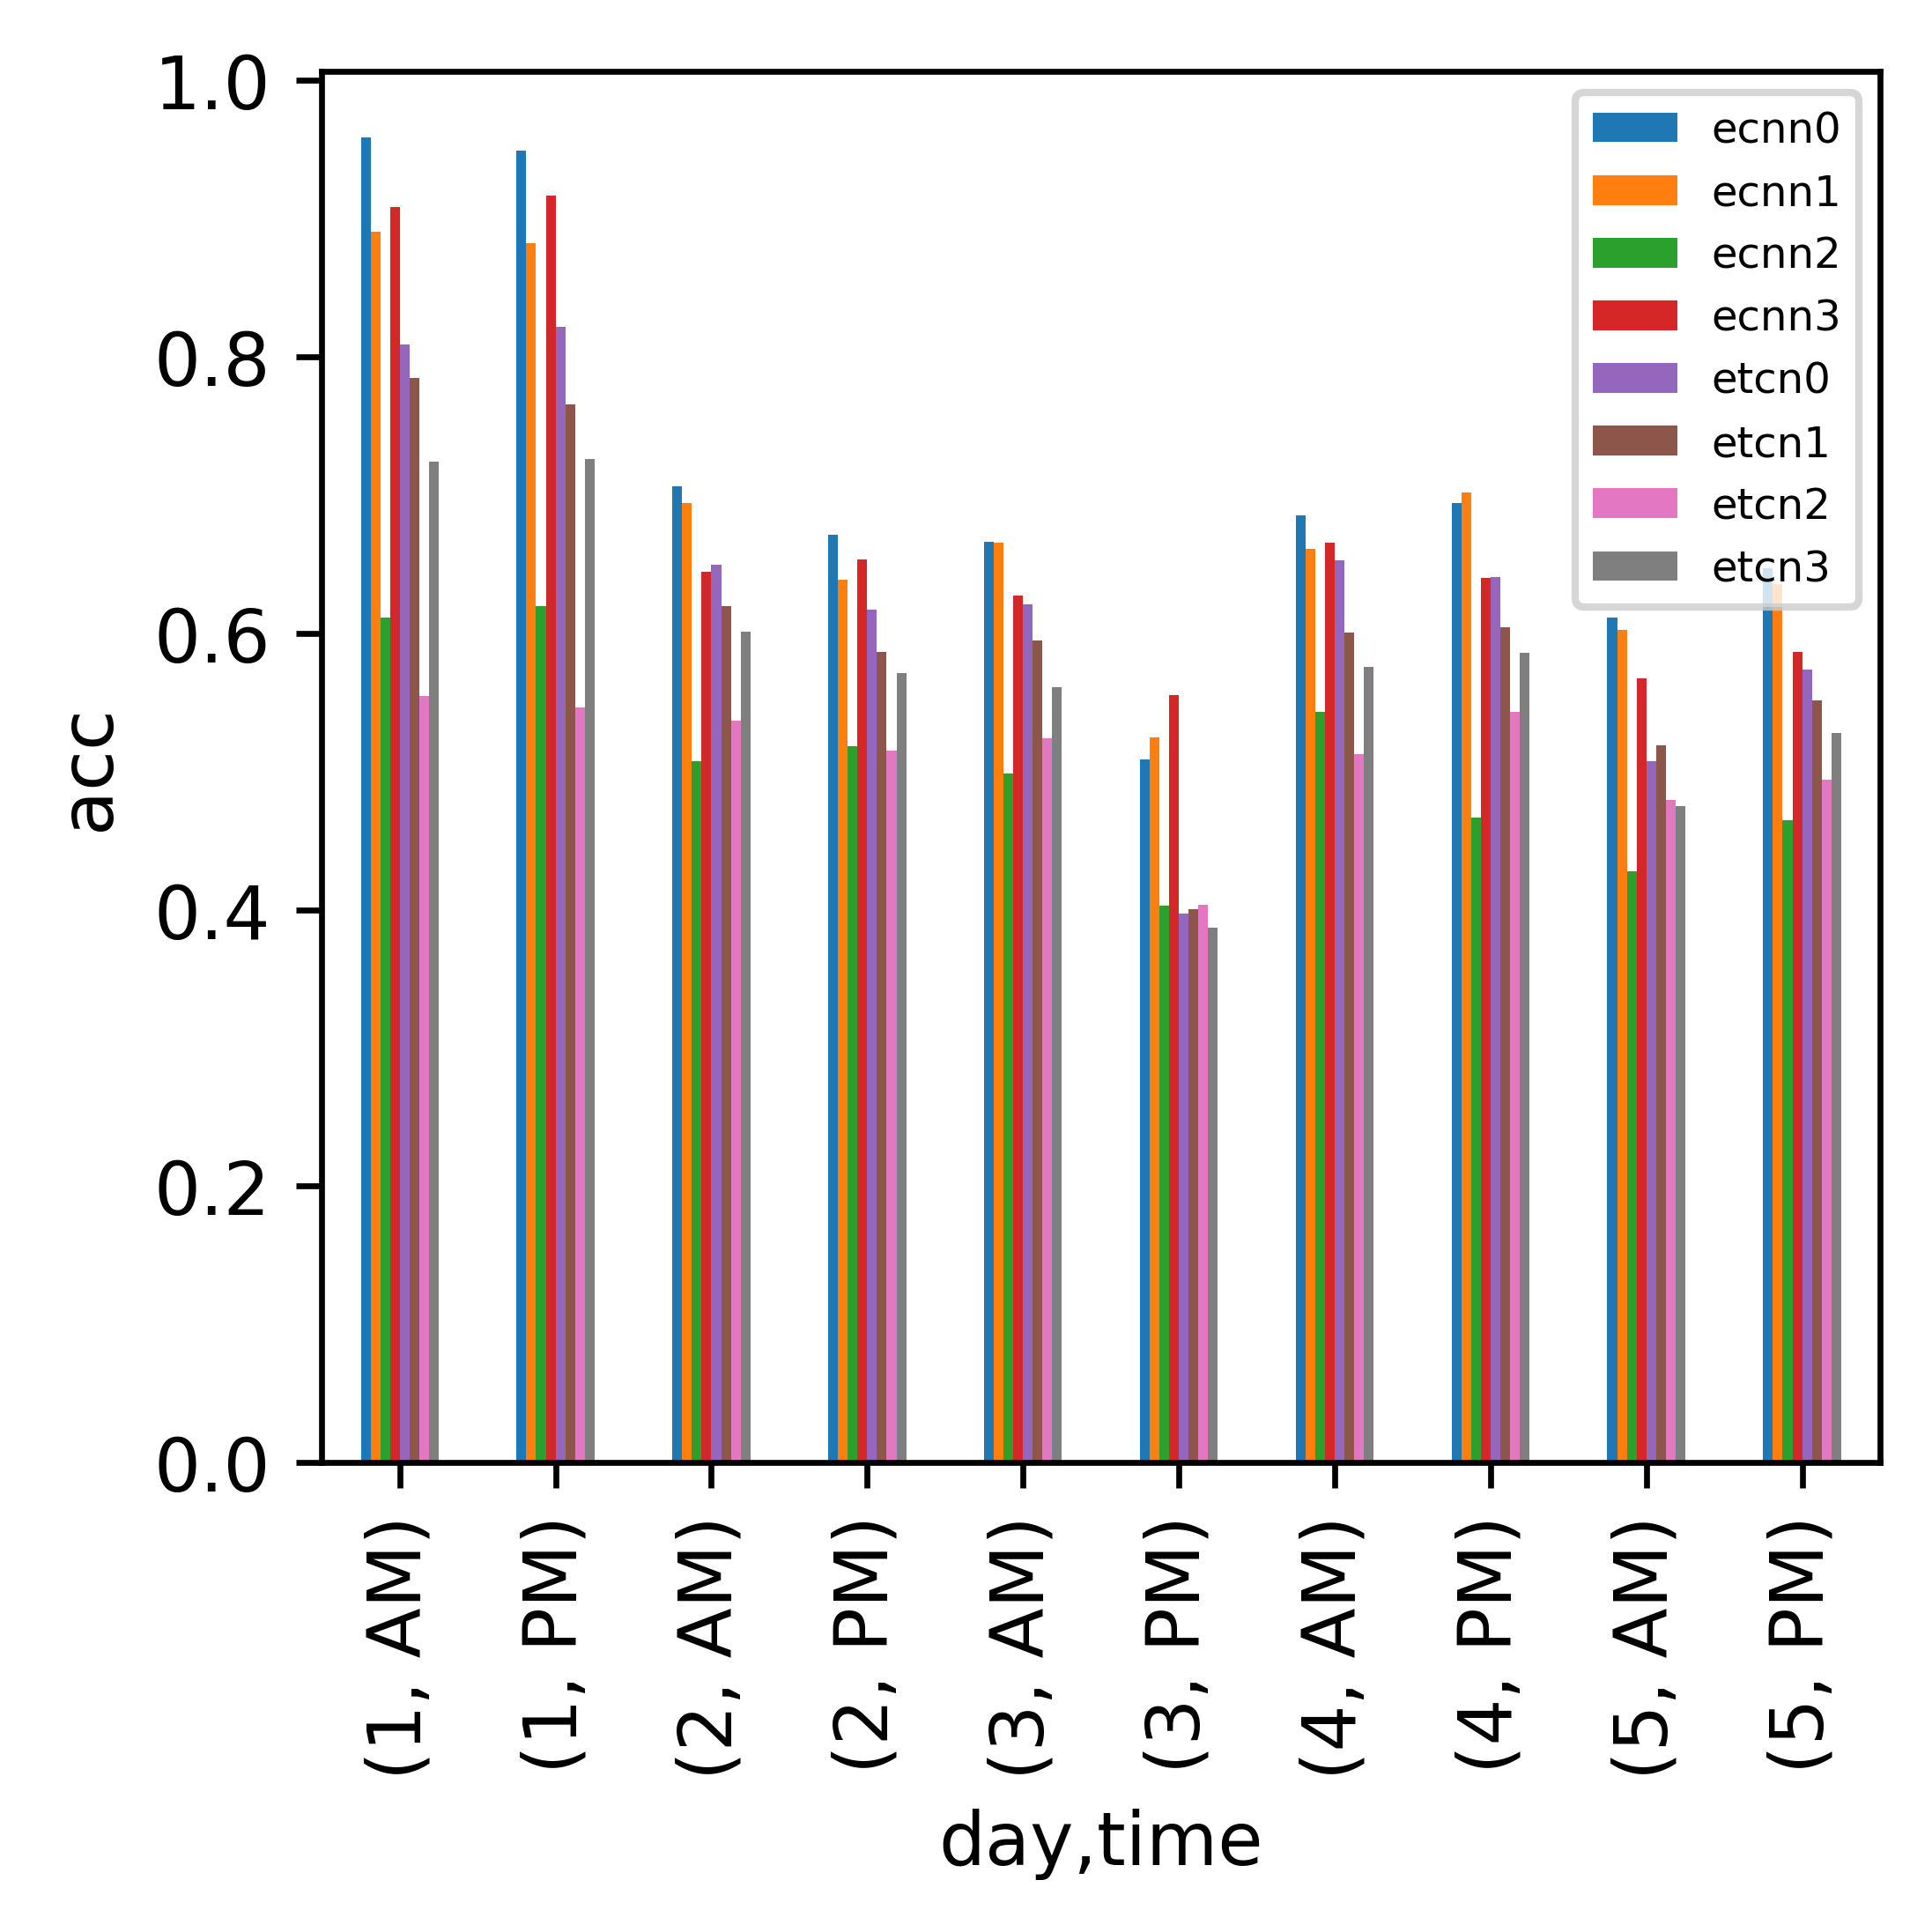

In [13]:

fig, ax = plt.subplots(1,1, figsize = (7.08/2, 7.08/2), constrained_layout=True,dpi=600)
df_acc_summary['acc'].plot(kind='bar', ax=ax, ylabel='acc')
ax.legend(loc='best', fontsize='xx-small')
#plt.savefig("./results/bar-acc.png", format='png', bbox_inches='tight', dpi=600, pad_inches=0.0)
plt.savefig("./analysis/bar-acc.png", format='png', bbox_inches='tight', dpi=600)
#f, axes = plt.subplots(1,1, figsize = (7.08/2, 7.08/2), constrained_layout=True,dpi=600)

#df_acc.groupby('model').boxplot(x='day',y='acc')

#df_acc.loc[df_acc['model']=='ecnn0'].boxplot(column = ['acc'], by=['day', 'time'], rot=45)

#df_acc.loc[df_acc['model']=='ecnn0'].boxplot(column = ['acc'], by=['day', 'time'], rot=45)
#for ax in axes.ravel():
#    ax = df_acc.plot.bar(x='day', y='acc')

'''
i=0
for ax in axes.ravel():
    #sns.heatmap(CM[i], ax = ax, cmap='GnBu')
    sns.
    colorbar = True if i==1 or i==3 else False
    sns.heatmap(CM_model_ave[i], ax = ax, annot=True, cmap='Blues', vmax=1, vmin=0, fmt='.2%', annot_kws={'size': 4}, cbar=colorbar)
    i+=1


labels = ['CNN','ECNN-A','ECNN-B','ECNN-C']
for ax, label in zip(axes.ravel(), labels):
    ax.set_title(label,loc='center', fontdict={'fontsize': 8})
    ax.set_xlabel('Predicted Finger Movement', fontdict={'fontsize': 8})
    ax.set_ylabel('Acutal Finger Movement', fontdict={'fontsize': 8})

plt.savefig("./results/confusion_matrix_macroave.eps", format='eps', bbox_inches='tight', dpi=600, pad_inches=0.0)
plt.savefig("./results/confusion_matrix_macroave.png", format='png', bbox_inches='tight', dpi=600, pad_inches=0.0)
'''

In [28]:

def cal_stability(y_p, y_t):
    c_p = np.sum(1-(np.equal(y_p[1:], y_p[:-1])))
    c_t = np.sum(1-(np.equal(y_t[1:], y_t[:-1])))
    s = 1 - np.abs(c_p-c_t)/(y_p.shape[0]-1)
    return s
 

a = np.array([0,0,0,1,1,1])
b = np.array([0,0,1,0,1,1])
s = cal_stability(b,a)
print(s)


0.6


In [35]:

def get_stability(model, sb):
    
    day_n_list = []
    time_n_list = []
    trial_n_list = []
    stability_list = []
    
    for day_n in range(1,6):
        for t_n in range(1,3):
            for T_n in range(1,13):
                tmp_R = pd.read_csv(os.getcwd()+f"/results/{model}/sb{sb}d{day_n}_t{t_n}_T{T_n}.csv")
                day_n_list.append(day_n)
                time_n_list.append('AM') if t_n == 1 else time_n_list.append('PM')
                #time_n_list.append(t_n)
                trial_n_list.append(T_n)
                stability_list.append(cal_stability(np.array(tmp_R['predict']), np.array(tmp_R['actual'])))

    
    n = len(stability_list)
    stability_dict={
            'model': [model]*n,
            'sb': [sb]*n,
            'day': day_n_list,
            'time': time_n_list,
            'trial': trial_n_list,
            'stability': stability_list
    }
    
    df = pd.DataFrame(stability_dict)
    return df

filename = './analysis/stability_report.csv'
models = ['ecnn0', 'ecnn1', 'ecnn2', 'ecnn3', 'etcn0', 'etcn1', 'etcn2', 'etcn3']

for i in models:
    df_new = get_stability(model=i, sb=1)
    if os.path.exists(filename):
        print('Update new')
        df = pd.read_csv(filename)
        df = df.append(df_new, ignore_index=True)
    else:
        print('Create new')
        df = df_new
    df.to_csv(filename, index=False)
    
df_stability = pd.read_csv(filename)

Create new
Update new
Update new
Update new
Update new
Update new
Update new
Update new


In [36]:
df_stability_summary = df_stability.groupby(by=['day', 'time','model']).mean().unstack()

In [37]:
df_stability_summary['stability']

model        ecnn0     ecnn1     ecnn2     ecnn3     etcn0     etcn1  \
day time                                                               
1   AM    0.968624  0.937324  0.809284  0.923310  0.867353  0.869062   
    PM    0.965219  0.937091  0.819359  0.927607  0.866268  0.860782   
2   AM    0.834800  0.853018  0.778974  0.790843  0.815688  0.826324   
    PM    0.821194  0.849373  0.785349  0.795885  0.809066  0.826808   
3   AM    0.821537  0.849774  0.796564  0.786623  0.804740  0.826649   
    PM    0.763415  0.824079  0.767013  0.752285  0.778081  0.831054   
4   AM    0.828022  0.851794  0.818888  0.795188  0.828711  0.845533   
    PM    0.848961  0.877151  0.800538  0.815463  0.822049  0.841480   
5   AM    0.800765  0.844243  0.742966  0.745383  0.788898  0.819155   
    PM    0.816885  0.858278  0.769505  0.761002  0.803777  0.824417   

model        etcn2     etcn3  
day time                      
1   AM    0.809222  0.858478  
    PM    0.768441  0.854097  
2   AM    0.801304  0.818530  
    PM    0.792023  0.822610  
3   AM    0.806850  0.816915  
    PM    0.788218  0.849793  
4   AM    0.800216  0.838753  
    PM    0.806998  0.838781  
5   AM    0.791938  0.807149  
    PM    0.802082  0.828236